In [1]:
#Extract bottom cell velocities and write to file

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [4]:
client = Client()#n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:40725 Dashboard: http://127.0.0.1:44267/status,Cluster Workers: 16 Cores: 16 Memory: 31.21 GiB


In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
expt='01deg_jra55v140_iaf'
variable='kmu'
kmu = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
kmu.load()
print(kmu.shape)

(2700, 3600)


In [6]:
s = '-01-01 00:00:00'
e = '-01-02 00:00:00'

for yr in range(2000,2001):
    start = str(yr)+s
    end = str(yr)+e
    print(start,end)
    
    u = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='u', 
                       session=session, frequency='1 daily',
                       start_time=start, 
                       end_time=end).sel(time=slice(start,end)).chunk({'st_ocean':75, 'yu_ocean':540, 'xu_ocean':720})
    
    print(u.shape)
    

2000-01-01 00:00:00 2000-01-02 00:00:00
(1, 75, 2700, 3600)


In [7]:
#this method is really slow ... use the masking method instead
#%%time
#ubot = u.isel(st_ocean=kmu)

In [8]:
#print(ubot.shape)
#ubot.plot(size=12, vmin=-0.5, vmax=0.5)

In [16]:
#ubot.to_netcdf(path='/g/data/v45/pas561/mom/archive/ubot_om2_01jraiaf/ubot_tst.nc')

https://nbviewer.jupyter.org/gist/aidanheerdegen/8d3e2f0a6edfb4c2693c3dd7091b1d93
Using the vector indexing above is convenient, but quite slow. Another option is to use masking.
So, below we create a mask of all the bottom cells by masking a single time slice of the u velocity data with itself but shifted "down" one cell in st_ocean.
In a second step turn it into a boolean array and rename.

In [9]:
bot_mask = u.isel(time=0).where(~xr.ufuncs.isfinite(u.isel(time=0).shift({'st_ocean':-1})))
bot_mask = ~xr.ufuncs.isnan(bot_mask).to_dataset(name='umask')
bot_mask

<xarray.Dataset>
Dimensions:   (st_ocean: 75, xu_ocean: 3600, yu_ocean: 2700)
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 2000-01-01 12:00:00
Data variables:
    umask     (st_ocean, yu_ocean, xu_ocean) bool dask.array<chunksize=(75, 540, 720), meta=np.ndarray>

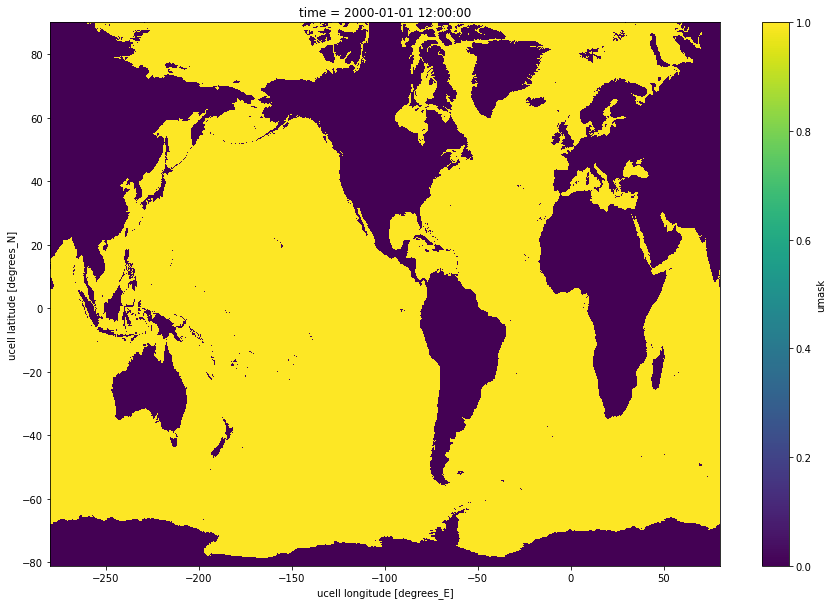

In [10]:
#To verify this has done what was expected, can sum the number of non-zero cells along each vertical axis. 
#Should be 1 for ocean cells, 0 for land
bot_mask.umask.sum(dim='st_ocean').plot(size=10);

In [11]:
%%time
bot_mask_sum = u.where(bot_mask.umask).sum('st_ocean')
bot_mask_sum

CPU times: user 8.68 ms, sys: 614 µs, total: 9.29 ms
Wall time: 8.38 ms


<xarray.DataArray 'u' (time: 1, yu_ocean: 2700, xu_ocean: 3600)>
dask.array<sum-aggregate, shape=(1, 2700, 3600), dtype=float32, chunksize=(1, 540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
  * time      (time) object 2000-01-01 12:00:00

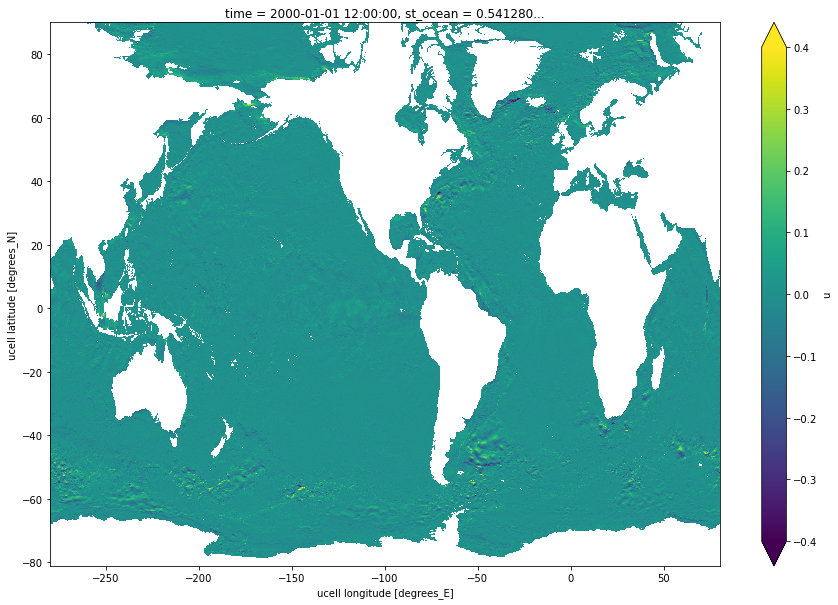

In [12]:
#Plot the first timeslice masked. Use where to mask out the land, which would otherwise just appear as zero velocities
bot_mask_sum.isel(time=0).where(xr.ufuncs.isfinite(u.isel(time=0).isel(st_ocean=0))).plot(size=10,vmin=-0.4,vmax=0.4);

In [13]:
#Confirm this identical to the vector indexed calculation from above
#(ubot - bot_mask_sum.isel(time=0)).sum().values

In [19]:
%%time
s = '-01 00:00:00'
e = '-01 00:00:00'

for yr in range(2000,2001):
    for mth in range(1,2):
        if (mth) < 9:
            start = str(yr)+'-0'+str(mth)+s
            end = str(yr)+'-0'+str(mth+1)+s
        elif(mth) < 10:
            start = str(yr)+'-0'+str(mth)+s
            end = str(yr)+'-'+str(mth+1)+s
        elif(mth) < 12:
            start = str(yr)+'-'+str(mth)+s
            end = str(yr)+'-'+str(mth+1)+s
        elif(mth) > 11:
            start = str(yr)+'-'+str(mth)+s
            end = str(yr+1)+'-0'+str(1)+s
        
        #start = '2000-01-01 00:00:00'
        #end = '2000-01-10 00:00:00'
        print(start,end)
        
        u = cc.querying.getvar(expt='01deg_jra55v140_iaf', variable='u', 
                       session=session, frequency='1 daily',
                       start_time=start, 
                       end_time=end).sel(time=slice(start,end)).chunk({'st_ocean':75, 'yu_ocean':540, 'xu_ocean':720})
    
        print(u.shape)
        
        ubot = u.where(bot_mask.umask).sum('st_ocean')
        #ubot = u.isel(st_ocean=kmu)
        print(ubot.shape)
        
        of='/g/data/v45/pas561/mom/archive/ubot_om2_01jraiaf/ubot_'+str(yr)+'_'+str(mth)+'.nc'
        print(of)
        ubot.to_netcdf(path=of)
    

2000-01-01 00:00:00 2000-01-10 00:00:00
(9, 75, 2700, 3600)
(9, 2700, 3600)
/g/data/v45/pas561/mom/archive/ubot_om2_01jraiaf/ubot_2000_1.nc


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ("('concatenate-open_dataset-getitem-82d226c2995a90cb218631c197869b67', 4, 2, 6, 1)", <Worker 'tcp://127.0.0.1:32795', name: 3, memory: 0, processing: 2543>)